In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
import mapping
from pyDepfetReader import FileReader
from epics_utils import get_pv

max_row = 768
max_col = 256


mean pede0 101.08084615071614
mean pede1 100.07070922851562
diff, mean: -1.0101, stfd: 1.7229
H2042, delta_pede>7 (noisy pixels): 0, occ: 0.0000


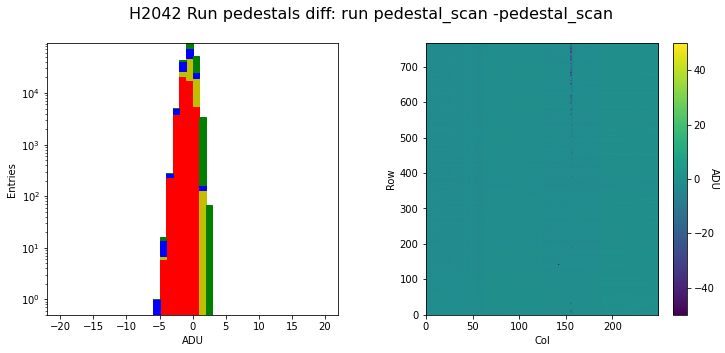

In [73]:
### compare pedestals

import os
import numpy as np
from matplotlib import pyplot as plt
import mapping
import argparse
import epics_utils
import matplotlib

# path0 = '/Data2/W53-IF/pedestal_scan/2020_10_27_010'
# path1 = '/Data2/W53-IF/pedestal_scan/2020_10_27_011'
dhes = ['H1011']

path0 = '/Data2/W56-OB2/pedestal_scan/2021_03_19_028'
path1 = '/Data2/W56-OB2/pedestal_scan/2021_03_19_029'


dhes = ['H2042']



path=[path0,path1]

for dhe in sorted(dhes):
    path = [os.path.join(path0, dhe), os.path.join(path1, dhe)]
    if not all(os.path.exists(x) for x in path):
        print("[INFO   ] {}: Data not found".format(dhe))
        continue
    peds = [np.load(os.path.join(x, 'analysis.npy'), allow_pickle=True).item() for x in path]
    peds = [np.concatenate([x['PXD:{}:D1:pedestal_data_512'.format(dhe)]
                            ,x['PXD:{}:D2:pedestal_data_512'.format(dhe)]
                            ,x['PXD:{}:D3:pedestal_data_512'.format(dhe)]
                            ,x['PXD:{}:D4:pedestal_data_512'.format(dhe)]
                           ], axis=1)
            for x in peds]
    # plt.figure(figsize=(5, 10))
    module_flavor = get_pv("PXD:B:config-"+dhe,"module_type:VALUE:set").get()
    print 
    
    mapper = mapping.mapper(module_type='pxd9', module_flavor=module_flavor, asicpair=0)
    # ped_diff = mapper(peds[0])
    ped_diff = peds[1].astype(np.int16) - peds[0].astype(np.int16)
    ped_diff_mapped = mapper(ped_diff)
    
    print('mean pede0', np.mean(peds[0]))
    print('mean pede1', np.mean(peds[1]))
    print('diff, mean: %.4f, stfd: %.4f'%(np.mean(ped_diff),np.std(ped_diff)))
    noisynr = len(np.where(ped_diff>7)[0])
    print('%s, delta_pede>7 (noisy pixels): %i, occ: %.4f'%(dhe, noisynr, noisynr/(768*2.5)))
    
    fig, axs = plt.subplots(1, 2,figsize=(12, 5))
#     fig.suptitle("Difference of mean pedestals DHE {}".format(dhe), fontsize=16)
    fig.suptitle("%s Run pedestals diff: run %s -%s"%(dhe,path1.split('/')[-2],path0.split('/')[-2]), fontsize=16)

    # plotting limits

#     adc_min = np.floor(np.amin(ped_diff)) - 0.5
#     adc_max = np.ceil(np.amax(ped_diff)) + 0.5
    adc_min = -20
    adc_max = 20
    vmax = 50
    vmin = -50
    
    # pedestal distribution as histogram (try stacked plotting)
    try:
        # num_bins = 100
        # prev = np.zeros(num_bins)
        color = ['r', 'y', 'b', 'g']
        color_i = 0

#            print(np.amax(ped_diff))
#            print(np.amin(ped_diff))
        num_bins = int(np.ceil(adc_max - adc_min))
        prev = np.zeros(num_bins)
        step = max(1, np.floor(float(adc_max - adc_min) / num_bins))
#            print(step)
#        print "[DEBUG  ] {}: Pedestal min {:3d}, Pedestal max {:3d}, pedestal step size {}".format(dhe, np.amin(ped_diff), np.amax(ped_di
#            bins = np.arange(np.amin(ped_diff), np.amax(ped_diff)+step*0.1, step)
        bins = np.arange(adc_min, adc_min + step * (num_bins) + 1, step)

        for pedestal_data_i in [(ped_diff[:768, 64 * i:64 * (i + 1)]).flatten() for i in range(4)]:
            n_tmp, bins, patches = axs[0].hist(pedestal_data_i, histtype='bar', bins=bins, fill=True, stacked=False,
                                               alpha=1, width=1,
                                               label="pedestals", align='mid', edgecolor=color[color_i],
                                               bottom=prev,
                                               color=color[color_i])
            prev += n_tmp
            color_i += 1
        axs[0].set_ylim(0.5, np.amax(prev))
        axs[0].set_yscale(r'log')
        axs[0].set_xlabel('ADU')
        axs[0].set_ylabel('Entries')
    except Exception as e:
        print("[WARNING] {}: Could not do stacked pedestals histogram plot due to".format(dhe))
        print(repr(e))

    im = axs[1].imshow(ped_diff_mapped, origin="lower", aspect="auto", vmin=vmin, vmax=vmax)
    #im = axs[1].imshow(ped_diff_mapped, origin="lower", aspect="auto", vmin=adc_min, vmax=adc_max)

    axs[1].set_xlabel('Col')
    axs[1].set_ylabel('Row')
    cbar = plt.colorbar(im)
    cbar.ax.set_ylabel('ADU', rotation=270)
    plt.subplots_adjust(wspace=0.3)
    #plt.savefig(os.path.join(args.outputpath, "ped_difference_{}.pdf".format(dhe)), format="pdf")
    plt.show()



# Noise Distribution

H2042 H20 /Data2/W56-OB2/pedestal_scan/2021_03_19_030
/Data2/W56-OB2/pedestal_scan/2021_03_19_030/H20rawframe_data.dat
(768, 256, 183)
dict_keys(['cm_data', 'cm_mean', 'cm_noise', 'mean', 'noise', 'hits', 'cm_vals'])
(192, 1024)
Nosiy pixels:  73


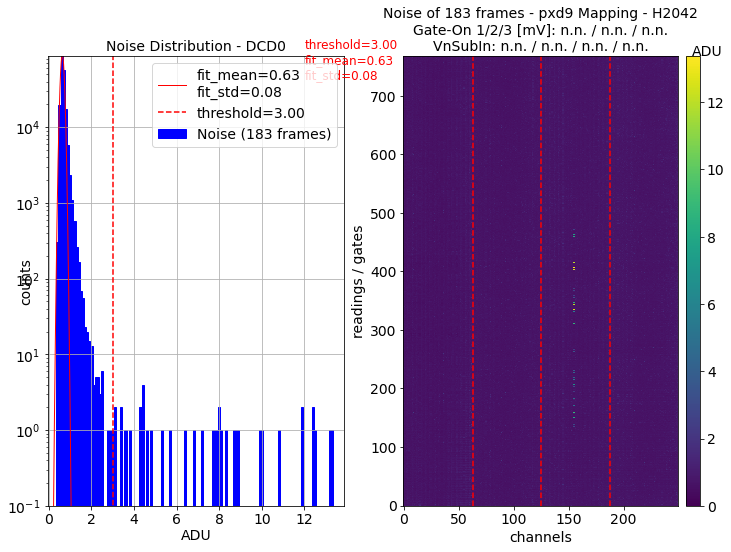

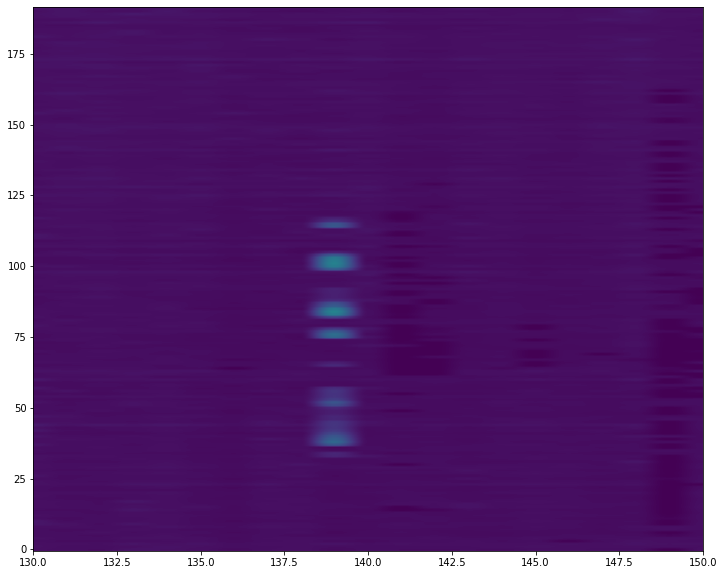

In [5]:
import config_utils
import file_utils
import mapping
import numpy as np
import os
from matplotlib import pyplot as plt
from calibrations.pedestal.analysis import calculate_pedestal_with_cm
import plots
from epics_utils import get_pv

# path = '/Data2/W53-IF/pedestal_scan/2020_10_26_003'
# path = '/Data2/W53-IF/pedestal_scan/2020_10_26_005'
# path = '/Data2/W53-IF/pedestal_scan/2020_10_22_006'
# path = '/Data2/W53-IF/pedestal_scan/2020_10_26_015'
# path = '/Data2/W53-IF/pedestal_scan/2020_10_27_013'

# path = '/Data2/W56-OB2/pedestal_scan/2021_03_17_022'
# path = '/Data2/W56-OB2/pedestal_scan/2021_03_18_021'
path = '/Data2/W56-OB2/pedestal_scan/2021_03_19_030'

dhc = 'H20'
dhe = 'H2042'

print(dhe,dhc,path)

# module_flavor = get_pv("PXD:B:config-"+dhe,"module_type:VALUE:set").get()
module_flavor = 'ob'

mapper = mapping.mapper(module_type='pxd9', module_flavor=module_flavor, asicpair=0)

# filename = '/Data2/W56-OB2/power_cycle_scan/2021_03_17_004/H20_pedestals_loop_005.dat'
filename = os.path.join(path, "%srawframe_data.dat" % dhc)
print(filename)

try:
    data = file_utils.read_raw_file(filename, dhe, asicpair= 0,
                                frames=200, use_header=True, skip_broken_frames=True)[0]
except Exception as e:
    print(e)

print(data.shape)

# nframes = data.shape[2]

drain_mask = np.full(256, False, dtype=np.bool)
drain_mask[10:16] = True

result = calculate_pedestal_with_cm(data, drain_mask,threshold=5)

# ped = result['cm_data']

print(result.keys())

# plots.plot_pedestals(data=result['cm_data'], module=dhe, device='pxd9', module_type=module_flavor, asicpair=0)
plots.plot_noise(data=result['cm_data'], device='pxd9', module=dhe, module_type=module_flavor, asicpair=0)

print('Nosiy pixels: ',len(np.where(result['noise']>2.5)[0]))

#################

elec_noise = mapping.matrixToDcd(result['noise'])
print(elec_noise.shape)
fig, ax = plt.subplots(figsize=(12, 10))
ax.imshow(elec_noise[:,512:768], origin="lower", aspect="auto", vmin=0, vmax=30)
# ax.set_xlim(130,150)


/Data2/W56-OB2/power_cycle_scan/2021_03_17_004/H20_pedestals_loop_005.dat


Text(0, 0.5, 'ADU')

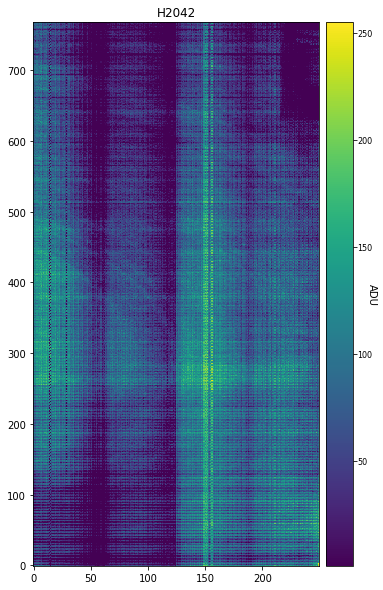

In [27]:
## read pedestals from raw data

import config_utils
import file_utils
import mapping
import os
import numpy as np
from matplotlib import pyplot as plt


def raw_pede(path, dhcs):
    print('read raw pedestals from %s'%path)

    peds_m={}
    for dhc in dhcs:
        for module in dhc.modules:
            
            filename = os.path.join(path, "%srawframe_data.dat" % dhc.name)
            try:
                data = file_utils.read_raw_file(filename, module.dhe, asicpair= 0,
                                            frames=200, use_header=True, skip_broken_frames=True)[0]
            except Exception as e:
                print(module.dhe, e)
                continue

            mapper = mapping.mapper(module_type='pxd9', module_flavor=module.module_flavor, asicpair=0)
            prelimPed = np.median(data, axis=2)
            peds_m[module.dhe] = mapper(prelimPed)
#             peds_m[module.dhe] = np.median(data, axis=2)

    return peds_m

### draw pedestals from raw data


filename = '/Data2/W56-OB2/power_cycle_scan/2021_03_17_004/H20_pedestals_loop_005.dat'

#dhcs = config_utils.get_setup_from_master_config()
#dhes = [module.dhe for dhc in dhcs for module in dhc.modules]
dhc = 'H20'
dhe = 'H2042'
module_flavor = 'ob'
try:
    data = file_utils.read_raw_file(filename, dhe, asicpair= 0,
                        frames=200, use_header=True, skip_broken_frames=True)[0]
except Exception as e:
    print(dhe, e)

mapper = mapping.mapper(module_type='pxd9', module_flavor=module_flavor, asicpair=0)
prelimPed = np.median(data, axis=2)
pede_m = mapper(prelimPed)

print(filename)
fig = plt.figure(figsize=(6,10))
ax = fig.add_subplot()    

pos = ax.imshow(pede_m, interpolation="none",origin="lower", aspect="auto")
ax.set_title(dhe)            
cbar = fig.colorbar(pos, fraction=0.126,pad=0.02,orientation="vertical")
cbar.ax.tick_params(labelsize=8, pad=1)
cbar.ax.set_ylabel('ADU', rotation=270)


## manually change offset

dict_keys(['PXD:H2042:D3:offset_data', 'PXD:H2042:R3:dacipdac:VALUE:set', 'PXD:H2042:R3:dacvnsubin:VALUE:set', 'PXD:H2042:R3:dacipaddin:VALUE:set', 'PXD:H2042:D4:offset_data', 'PXD:H2042:R4:dacipdac:VALUE:set', 'PXD:H2042:R4:dacvnsubin:VALUE:set', 'PXD:H2042:R4:dacipaddin:VALUE:set', 'PXD:H2042:D2:offset_data', 'PXD:H2042:R2:dacipdac:VALUE:set', 'PXD:H2042:R2:dacvnsubin:VALUE:set', 'PXD:H2042:R2:dacipaddin:VALUE:set', 'PXD:H2042:D1:offset_data', 'PXD:H2042:R1:dacipdac:VALUE:set', 'PXD:H2042:R1:dacvnsubin:VALUE:set', 'PXD:H2042:R1:dacipaddin:VALUE:set'])
(768, 64)
(192, 256)


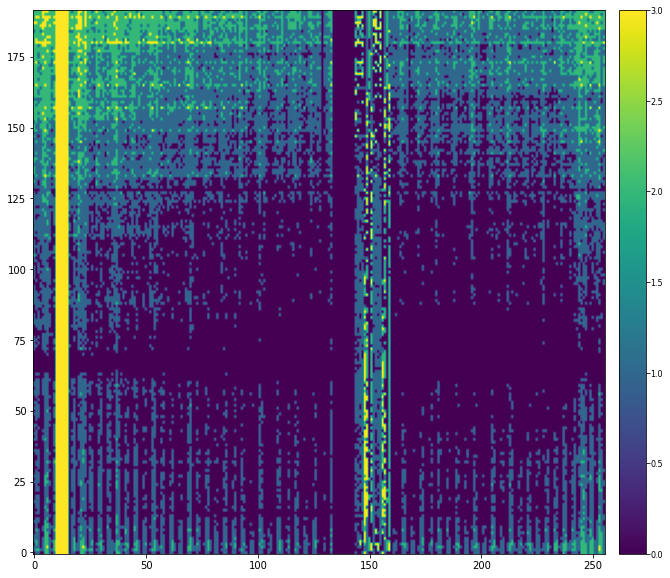

In [6]:
# filename = '/Data2/W53-IF/offsets_calibration/2020_10_26_002/H1011/analysis.npy'
# asic = 'PXD:H1011:D4:offset_data'
# module_flavor = 'if'

filename = '/Data2/W56-OB2/offsets_calibration/2021_03_17_001/H2042/analysis.npy'
asic = 'PXD:H2042:D3:offset_data'
module_flavor = 'ob'

ana = np.load(filename, allow_pickle=True).item()
print(ana.keys())

print(ana[asic].shape)

mapper = mapping.mapper(module_type='pxd9', module_flavor=module_flavor, asicpair=0)
dcd = mapping.matrixToDcd(ana[asic])
print(dcd.shape)

## W56_OB2: adc channel 641, 651-653 
dcd[:,129] = 0
dcd[:,134:144] = 0
# dcd[:,:] = 0
ana[asic] = mapping.dcdToMatrix(dcd)

ana['PXD:H2042:R1:dacvnsubin:VALUE:set'] = 30
ana['PXD:H2042:R2:dacvnsubin:VALUE:set'] = 29
ana['PXD:H2042:R3:dacvnsubin:VALUE:set'] = 25
ana['PXD:H2042:R4:dacvnsubin:VALUE:set'] = 25


np.save(filename.replace('analysis', 'analysis_2'), ana)

fig, ax = plt.subplots(figsize=(12, 10))
pos = ax.imshow(dcd, origin="lower", aspect="auto", vmin=0, vmax=3)
cbar = fig.colorbar(pos, fraction=0.126,pad=0.02,orientation="vertical")
cbar.ax.tick_params(labelsize=8, pad=1)
# cbar.ax.set_ylabel('ADU', rotation=270)
